In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.


In [5]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from scipy.stats import boxcox
from sklearn import metrics # for the check the error and accuracy of the model

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [6]:
#reading and concatinating customer data
raw_1 = pd.read_excel('D:/UK/assignment/DSA8023/WB1_Energia_Challenge_March_2023_Data.xlsx', sheet_name=1)
raw_2 = pd.read_excel('D:/UK/assignment/DSA8023/WB2_Energia_Challenge_March_2023_Data.xlsx', sheet_name=1)
raw_d = pd.concat([raw_1, raw_2])

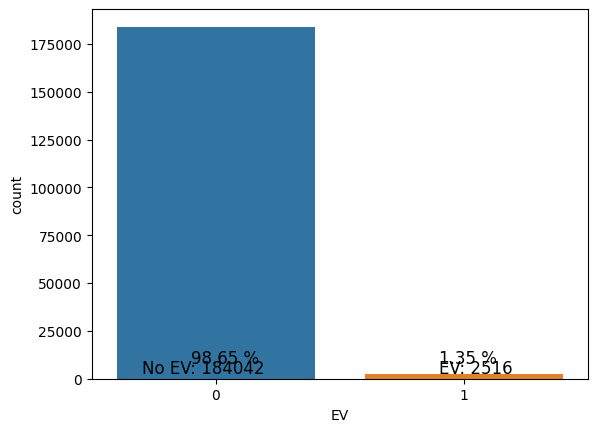

In [10]:
# len(raw_d) - len(raw_d[raw_d.EV == 'N'])


def visualizeFeatureCount(dataset, feature = 'EV'):
    totalData = len(dataset)
    hasFeature = dataset[feature].sum()
    
#     print(totalData, has)
    hasNoFeature = totalData - hasFeature

    hasFeature_per = round(hasFeature/totalData * 100, 2)
    hasNoFeature_per = round(hasNoFeature/totalData * 100, 2)

    plt.figure()
    sns.countplot(data = dataset, x=feature)
    plt.annotate('No {}: {}'.format(feature, hasNoFeature), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
    plt.annotate('{}: {}'.format(feature, hasFeature), xy=(0.7, 15000), xytext=(0.9, 3000), size=12)
    plt.annotate(str(hasNoFeature_per)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
    plt.annotate(str(hasFeature_per)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
    plt.show()

data['title'] = data['title'].replace([' '], 'Unclassified')

rename_obj = {
    'agedBand': {'Unclassified' : 0,'19 to 24': 1, '25 to 40': 2,'41 to 50': 3, '51 to 60': 4, '61 to 70': 5,'70+': 6, '18 & Under': 7},
    'signedUpGroup': {'Telesales': 0, 'PCW': 1, 'Field Sales': 2, 'Web': 3, 'OBS': 4,'Other': 5},
    'title': {'Ms': 0, 'Mr': 1, 'Mrs': 2, 'Dr': 3, 'Miss': 4, 'Mr & Mrs': 5, 'Rev': 6, 'Unclassified': 7},
    'EV': {'N': 0, 'Y': 1},
    'EV_New_or_Old': {'Non-EV Customers': 0, 'Switched to EV': 1, 'New EV Customer': 1},
    'saStatus': {'Active': 1}
}

# for mosaic using label encoder
le = LabelEncoder()
 
labels = le.fit_transform(data['mosaicType'])

data['mosaicType'] = labels

data = data.replace(rename_obj)
visualizeFeatureCount(raw_d, )

In [50]:
# taking a copy from raw data for cleaning
df = raw_d.copy()

df.head()

,accountID,StartDate,ContractStartDateEV,contractStartDate,contractEndDate,saStatus,agedBand,signedUpGroup,title,mosaicType,...,bill_4_2021,bill_5_2021,bill_6_2021,bill_1_2022,bill_2_2022,bill_3_2022,bill_4_2022,bill_5_2022,bill_6_2022,bill_1_2023
0,0,2022-05-03,NaT,2022-05-03,2023-05-03,Active,41 to 50,PCW,Mr,NaN,...,0.0,0.0,0.0,0.0,0.0,581.0,542.0,696.0,0.0,2813.0
1,1,2018-03-09,NaT,2023-03-14,2024-03-14,Active,Unclassified,Telesales,Ms,F17,...,926.0,1131.0,1081.0,1200.0,1179.0,1182.0,985.0,917.0,983.0,1130.0
2,2,2022-01-14,NaT,2023-01-15,2024-01-15,Active,Unclassified,Other,Mr,G18,...,0.0,0.0,0.0,381.0,706.0,629.0,681.0,848.0,1455.0,0.0
3,3,2021-03-23,NaT,2021-03-23,2022-03-23,Active,41 to 50,Other,Mrs,K31,...,348.0,343.0,456.0,470.0,381.0,364.0,333.0,397.0,407.0,526.0
4,4,2020-10-29,NaT,2021-10-30,2022-10-30,Active,Unclassified,Telesales,Mr,NaN,...,663.0,265.0,313.0,497.0,183.0,250.0,234.0,381.0,358.0,233.0


In [51]:
#defining necessary billing columns
bill_months = ['bill_1_2021', 'bill_2_2021',
       'bill_3_2021', 'bill_4_2021', 'bill_5_2021', 'bill_6_2021',
       'bill_1_2022', 'bill_2_2022', 'bill_3_2022', 'bill_4_2022',
       'bill_5_2022', 'bill_6_2022', 'bill_1_2023']

print(len(bill_months))

# based on the fact that ifn one reading is missed for a particular month, the reading will be accumulated to next month.
# the reading is averaged between missing and accumulated months.
# only one missed month is accepted thus eleminating rows with consecutive zeros
# end result will have no zero readings
def average_missing_months(x):
    for index, month in enumerate(bill_months[:-1]):
        next_month = bill_months[index+1]
        if x[month] == 0:
            if(x[next_month] != 0):
                x[month] = x[next_month] / 2
                x[next_month] = x[next_month] / 2
            else:
                break
    return x

13


In [52]:
df = df.apply(average_missing_months, axis=1)

In [53]:
# eleminating zero reading observations
data = df[~df[bill_months].isin([0]).any(axis=1)]

In [54]:
# checking with actual data
# df[bill_months].isin([0]).sum()
data[bill_months].isin([0]).sum()
# data.to_excel('D:/UK/assignment/DSA8023/Cleaned_v1_WB_Energia_Challenge_March_2023_Data.xlsx')

bill_1_2021    0
bill_2_2021    0
bill_3_2021    0
bill_4_2021    0
bill_5_2021    0
bill_6_2021    0
bill_1_2022    0
bill_2_2022    0
bill_3_2022    0
bill_4_2022    0
bill_5_2022    0
bill_6_2022    0
bill_1_2023    0
dtype: int64

In [59]:
# visualizations - countplot

def visualizeFeatureCount(dataset, feature = 'EV'):
    totalData = len(dataset)
    hasFeature = dataset[feature].sum()
    
#     print(totalData, has)
    hasNoFeature = totalData - hasFeature

    hasFeature_per = round(hasFeature/totalData * 100, 2)
    hasNoFeature_per = round(hasNoFeature/totalData * 100, 2)

    plt.figure()
    sns.countplot(data = dataset, x=feature)
    plt.annotate('No {}: {}'.format(feature, hasNoFeature), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
    plt.annotate('{}: {}'.format(feature, hasFeature), xy=(0.7, 15000), xytext=(0.9, 3000), size=12)
    plt.annotate(str(hasNoFeature_per)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
    plt.annotate(str(hasFeature_per)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
    plt.show()

data.tail(10)


,accountID,StartDate,ContractStartDateEV,contractStartDate,contractEndDate,saStatus,agedBand,signedUpGroup,title,mosaicType,...,bill_4_2021,bill_5_2021,bill_6_2021,bill_1_2022,bill_2_2022,bill_3_2022,bill_4_2022,bill_5_2022,bill_6_2022,bill_1_2023
86535,186535,2015-03-10,NaT,2019-04-05,2020-04-04,1,0.0,2,0,43,...,2486.0,1262.0,295.0,272.0,223.0,175.0,153.0,390.0,268.0,250.0
86538,186538,2021-02-03,NaT,2021-02-03,2022-02-03,1,0.0,1,1,40,...,1402.0,1374.0,1148.0,1399.0,872.0,732.0,790.0,775.0,1224.0,1145.0
86539,186539,2021-02-13,NaT,2023-02-15,2024-02-15,1,2.0,3,1,28,...,1196.0,1253.0,1929.0,1110.0,3361.0,3345.0,671.0,1167.0,806.0,1897.0
86543,186543,2019-12-11,NaT,2022-12-13,2023-12-13,1,0.0,5,1,16,...,1516.0,671.0,882.0,408.5,408.5,1290.0,1.0,1355.5,1355.5,688.0
86544,186544,2018-01-30,NaT,2018-01-30,2019-01-30,1,3.0,4,4,7,...,237.0,189.0,276.0,282.0,294.0,239.0,192.0,206.0,264.0,284.0
86546,186546,2020-12-31,NaT,2022-02-01,2023-02-01,1,3.0,1,2,1,...,693.0,640.0,1089.0,1320.0,1154.0,916.0,721.0,682.0,1082.0,1698.0
86548,186548,2016-04-07,NaT,2019-11-21,2020-11-20,1,2.0,5,1,17,...,669.0,682.0,1442.0,635.0,351.0,423.0,771.0,636.0,361.0,480.0
86551,186551,2019-07-18,NaT,2022-09-24,2023-09-24,1,0.0,2,1,25,...,251.0,227.0,235.0,228.0,220.0,213.0,258.0,197.0,209.0,167.0
86554,186554,2016-04-22,NaT,2016-04-22,2017-04-22,1,0.0,5,7,18,...,69.0,77.0,73.0,82.0,69.0,56.0,81.0,62.0,84.0,44.0
86556,186556,2021-01-02,NaT,2023-03-16,2024-03-16,1,2.0,3,0,28,...,263.0,1156.0,835.0,884.0,361.5,361.5,1151.0,551.0,1011.0,924.0


In [12]:
raw_d..unique()

SyntaxError: invalid syntax (4104343464.py, line 1)

In [169]:
# dropping rows with empty values in title
data['title'] = data['title'].replace([' '], 'Unclassified')

rename_obj = {
    'agedBand': {'Unclassified' : 0,'19 to 24': 1, '25 to 40': 2,'41 to 50': 3, '51 to 60': 4, '61 to 70': 5,'70+': 6, '18 & Under': 7},
    'signedUpGroup': {'Telesales': 0, 'PCW': 1, 'Field Sales': 2, 'Web': 3, 'OBS': 4,'Other': 5},
    'title': {'Ms': 0, 'Mr': 1, 'Mrs': 2, 'Dr': 3, 'Miss': 4, 'Mr & Mrs': 5, 'Rev': 6, 'Unclassified': 7},
    'EV': {'N': 0, 'Y': 1},
    'EV_New_or_Old': {'Non-EV Customers': 0, 'Switched to EV': 1, 'New EV Customer': 1},
    'saStatus': {'Active': 1}
}

# for mosaic using label encoder
le = LabelEncoder()
 
labels = le.fit_transform(data['mosaicType'])

data['mosaicType'] = labels

data = data.replace(rename_obj)


In [63]:

cols_to_delete = ['StartDate','ContractStartDateEV','contractStartDate','contractEndDate','saStatus', 'accountID']
if data.columns.isin(cols_to_delete).any():
    data = data.drop(columns=cols_to_delete)
    

In [61]:
# dropping rows with na in agedBand
data = data[data.agedBand.notna()]

# dropping rows with na in mosaicType
data = data[data.mosaicType.notna()]


# encoding categories in agedBand
# data.agedBand.unique()
# data.signedUpGroup.unique()
# data.title.isin([' '])



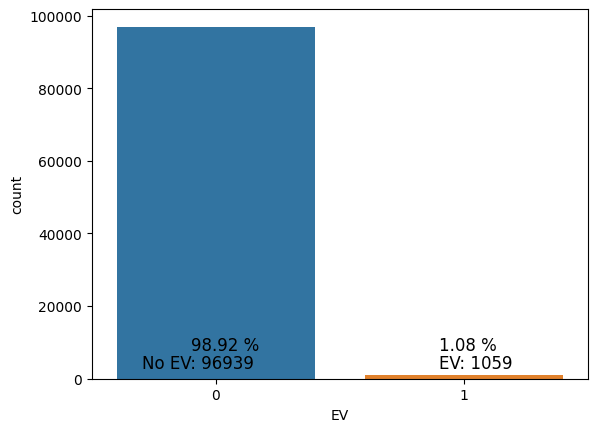

In [132]:
visualizeFeatureCount(data, 'EV')
# we have very less known data. Data augmentation has to be done

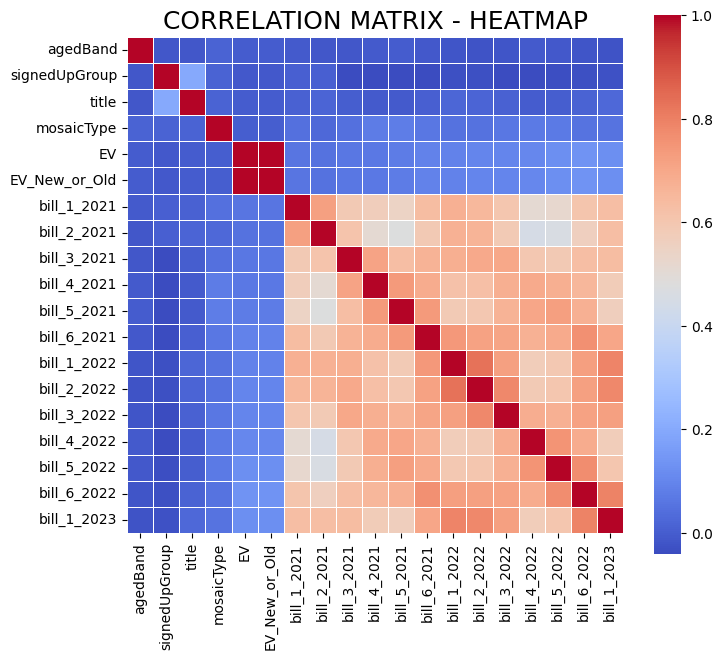

In [64]:
# visualizations - correlation - heatmap

corr = data.corr(numeric_only=True) # .corr is used to find corelation
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=18);


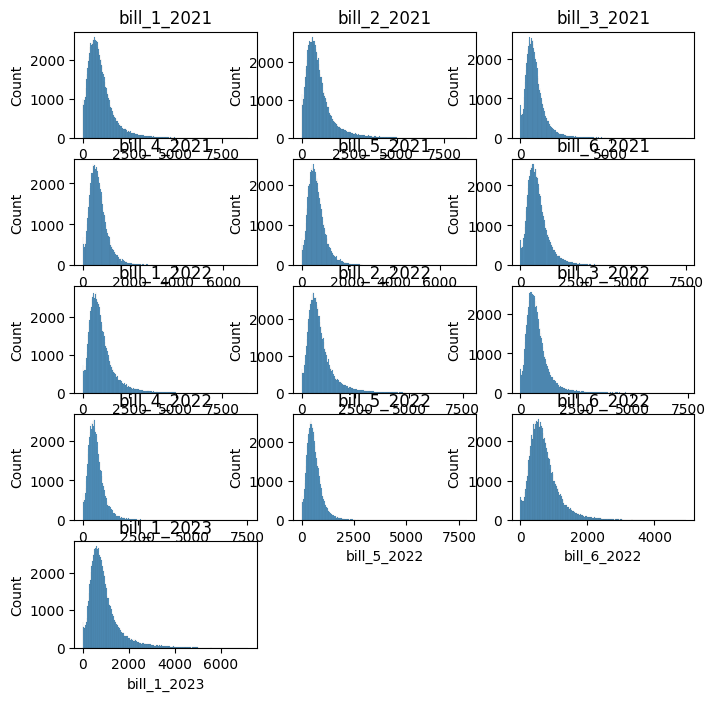

In [65]:
# plot data - histogram of billing features
def plot_hist_plots(t_data, t_features):
    f = plt.figure(figsize=(8,8))
    for i, feature in enumerate(t_features):
        t = f.add_subplot(5,3, i+1)
        sns.histplot(t_data[feature])
        t.title.set_text(feature)
    plt.show();


plot_hist_plots(data, bill_months)

# data is right skewed - need to transform the data


In [16]:
data.head()

,agedBand,signedUpGroup,title,mosaicType,EV,EV_New_or_Old,bill_1_2021,bill_2_2021,bill_3_2021,bill_4_2021,bill_5_2021,bill_6_2021,bill_1_2022,bill_2_2022,bill_3_2022,bill_4_2022,bill_5_2022,bill_6_2022,bill_1_2023
1,0,0,0,16,0,0,1278.0,1008.0,1278.0,926.0,1131.0,1081.0,1200.0,1179.0,1182.0,985.0,917.0,983.0,1130.0
6,3,1,2,36,0,0,803.5,803.5,1148.0,1025.0,928.0,1194.0,1221.5,1221.5,994.0,770.0,921.0,951.0,1134.0
9,4,2,1,41,0,0,726.0,587.0,550.0,448.0,494.0,1066.0,883.0,478.0,640.0,538.0,544.0,664.0,811.0
12,0,5,1,32,0,0,1570.0,198.0,1049.0,791.0,834.0,629.0,1325.0,959.0,747.0,713.0,601.0,784.0,1082.0
15,0,3,1,8,0,0,94.5,94.5,233.0,207.0,161.0,107.0,347.0,202.0,161.0,163.0,156.0,220.0,144.0


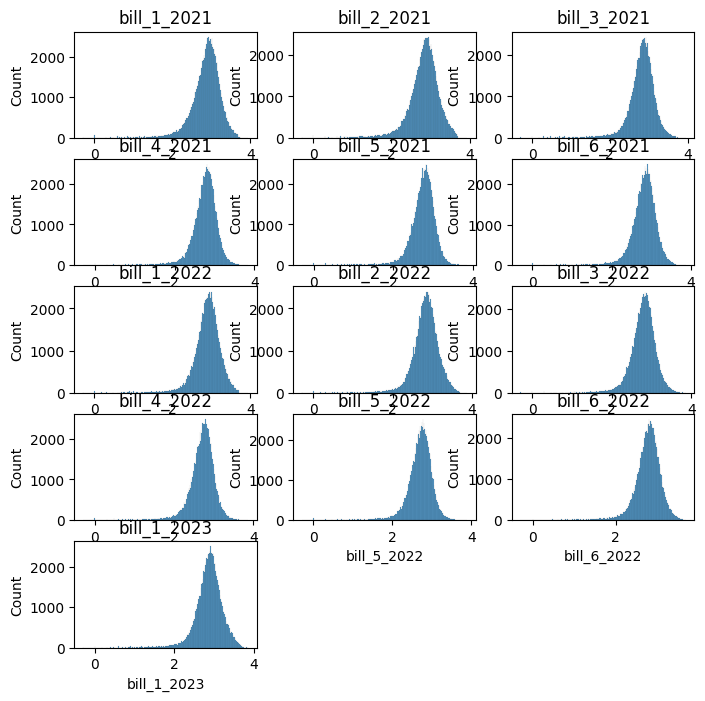

In [66]:
l_data = data.copy()

for month in bill_months:
    l_data[month] = np.log10(l_data[month])
    
# plot_hist_plots(l_data, bill_months)
l_data.head()

plot_hist_plots(l_data, bill_months)

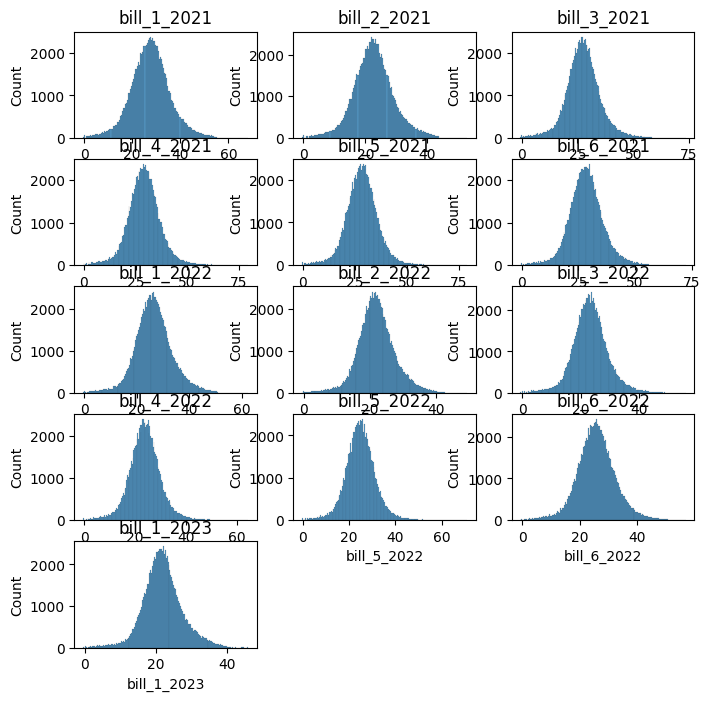

In [67]:
c_data = data.copy()

for month in bill_months:
    c_data[month] = boxcox(c_data[month])[0]
    
plot_hist_plots(c_data, bill_months)


Training set: Counter({0: 77551, 1: 847})
Testing set: Counter({0: 19388, 1: 212})
Training set: Counter({0: 77551, 1: 847})
Testing set: Counter({0: 19388, 1: 212})
Accuracy: 0.9891836734693877

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19388
           1       0.00      0.00      0.00       212

    accuracy                           0.99     19600
   macro avg       0.49      0.50      0.50     19600
weighted avg       0.98      0.99      0.98     19600


Average 5-Fold CV Score: 0.9892 , Standard deviation: 0.0


C:\Users\Varun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

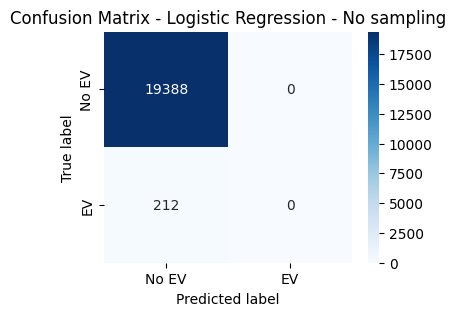

In [173]:

# building models with original data and with no sampling

data = c_data.copy()

x = data.drop('EV', axis=1)  
y = data['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)
print('Training set: {}'.format(Counter(y_train)))
print('Testing set: {}'.format(Counter(y_test)))

# scaler_robust = RobustScaler()
# X_train = scaler_robust.fit_transform(X_train)
# X_test = scaler_robust.fit_transform(X_test)

# frequency of each class after SMOTE
print('Training set: {}'.format(Counter(y_train)))
print('Testing set: {}'.format(Counter(y_test)))

LR = LogisticRegression(C=0.00005, random_state=0)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR, x, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['No EV', 'EV'], 
            yticklabels = ['No EV', 'EV'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression - No sampling");


y_pred_proba_LR = LR.predict_proba(X_test)[::,1]
LR1_fpr, LR1_tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_LR)
LR1_auc = metrics.roc_auc_score(y_test, y_pred_proba_LR)

Training set: Counter({0: 77551, 1: 847})
Testing set: Counter({0: 19388, 1: 212})
Training set: Counter({0: 847, 1: 847})
Testing set: Counter({0: 19388, 1: 212})
Accuracy: 0.6812244897959183

              precision    recall  f1-score   support

           0       0.99      0.68      0.81     19388
           1       0.02      0.67      0.04       212

    accuracy                           0.68     19600
   macro avg       0.51      0.68      0.43     19600
weighted avg       0.98      0.68      0.80     19600


Average 5-Fold CV Score: 0.9892 , Standard deviation: 0.0


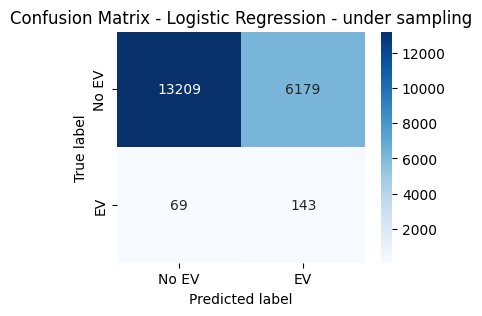

In [165]:

# building models with original data and with under sampling

data = c_data.copy()

x = data.drop('EV', axis=1)  
y = data['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)
print('Training set: {}'.format(Counter(y_train)))
print('Testing set: {}'.format(Counter(y_test)))

# scaler_robust = RobustScaler()
# X_train = scaler_robust.fit_transform(X_train)
# X_test = scaler_robust.fit_transform(X_test)

from imblearn.under_sampling import NearMiss

# perform undersampling
sm = NearMiss(version=1, n_neighbors=3)
X_train, y_train = sm.fit_resample(X_train, y_train)

# frequency of each class after SMOTE
print('Training set: {}'.format(Counter(y_train)))
print('Testing set: {}'.format(Counter(y_test)))

LR = LogisticRegression(C=0.00005, random_state=0)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR, x, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['No EV', 'EV'], 
            yticklabels = ['No EV', 'EV'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression - under sampling");




y_pred_proba_LR = LR.predict_proba(X_test)[::,1]
LR2_fpr, LR2_tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_LR)
LR2_auc = metrics.roc_auc_score(y_test, y_pred_proba_LR)

Training set: Counter({0: 77551, 1: 847})
Testing set: Counter({0: 19388, 1: 212})
Training set: Counter({0: 77551, 1: 77551})
Testing set: Counter({0: 19388, 1: 212})


C:\Users\Varun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8726020408163265

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     19388
           1       0.07      0.83      0.12       212

    accuracy                           0.87     19600
   macro avg       0.53      0.85      0.53     19600
weighted avg       0.99      0.87      0.92     19600


Average 5-Fold CV Score: 0.9892 , Standard deviation: 0.0


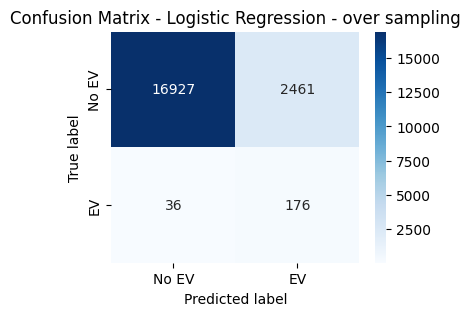

In [163]:

# building models with original data and with over sampling

data = c_data.copy()

x = data.drop('EV', axis=1)  
y = data['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)
print('Training set: {}'.format(Counter(y_train)))
print('Testing set: {}'.format(Counter(y_test)))

# scaler_robust = RobustScaler()
# X_train = scaler_robust.fit_transform(X_train)
# X_test = scaler_robust.fit_transform(X_test)

from imblearn.over_sampling import SMOTE 

# add artificial samples to training data only
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# frequency of each class after SMOTE
print('Training set: {}'.format(Counter(y_train)))
print('Testing set: {}'.format(Counter(y_test)))

LR = LogisticRegression(C=0.00005, random_state=0)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR, x, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['No EV', 'EV'], 
            yticklabels = ['No EV', 'EV'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression - over sampling");


y_pred_proba_LR = LR.predict_proba(X_test)[::,1]
LR3_fpr, LR3_tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_LR)
LR3_auc = metrics.roc_auc_score(y_test, y_pred_proba_LR)

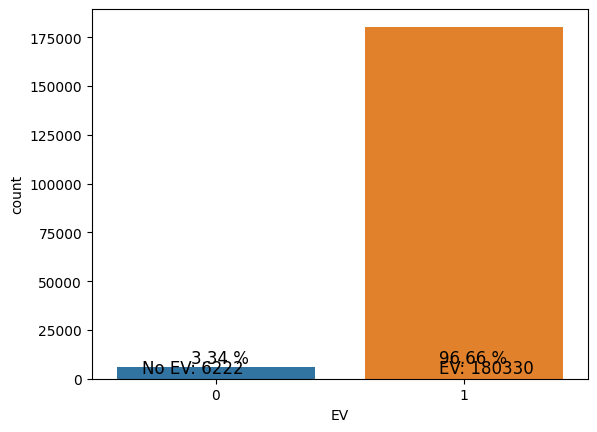

In [174]:
v_data = raw_d.copy()

# v_data = v_data[v_data.EV == 1]
v_data = v_data.drop(columns=cols_to_delete)

# dropping rows with empty values in title
v_data['title'] = v_data['title'].replace([' '], 'Unclassified')

rename_obj = {
    'agedBand': {'Unclassified' : 0,'19 to 24': 1, '25 to 40': 2,'41 to 50': 3, '51 to 60': 4, '61 to 70': 5,'70+': 6, '18 & Under': 7},
    'signedUpGroup': {'Telesales': 0, 'PCW': 1, 'Field Sales': 2, 'Web': 3, 'OBS': 4,'Other': 5},
    'title': {'Ms': 0, 'Mr': 1, 'Mrs': 2, 'Dr': 3, 'Miss': 4, 'Mr & Mrs': 5, 'Rev': 6, 'Unclassified': 7, 'Cllr': 8},
    'EV': {'N': 0, 'Y': 1},
    'EV_New_or_Old': {'Non-EV Customers': 0, 'Switched to EV': 1, 'New EV Customer': 1},
    'saStatus': {'Active': 1}
}

# for mosaic using label encoder
le = LabelEncoder()
 
labels = le.fit_transform(v_data['mosaicType'])

v_data['mosaicType'] = labels

v_data = v_data.replace(rename_obj)

# print(v)
v_data = v_data.drop(columns=['EV'])

v_data = v_data.dropna()
EV = LR.predict(v_data)

v_data['EV'] = EV

visualizeFeatureCount(v_data, 'EV')

In [140]:
# v_data.head())

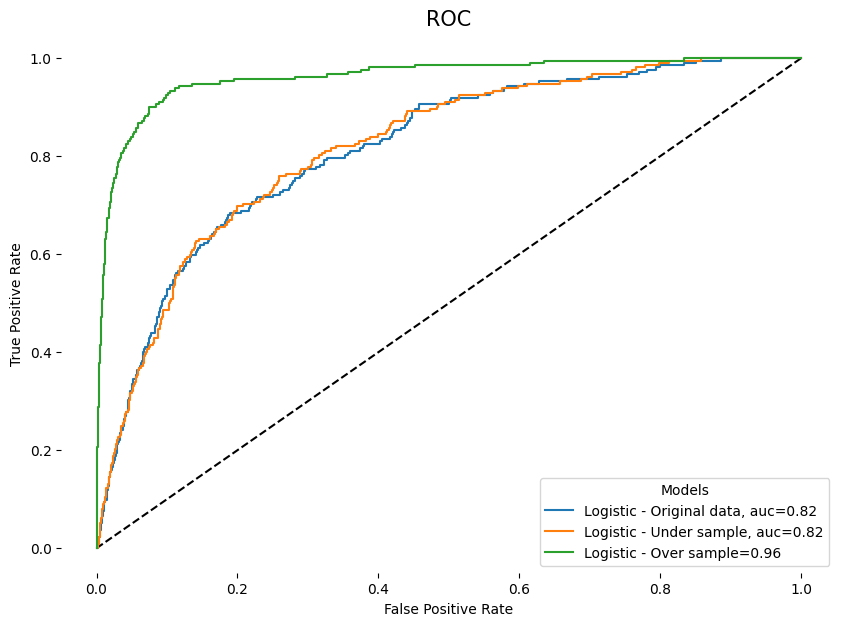

In [119]:
E
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(LR1_fpr,LR1_tpr,label="Logistic - Original data, auc="+str(round(LR1_auc,2)))
plt.plot(LR2_fpr,LR2_tpr,label="Logistic - Under sample, auc="+str(round(LR2_auc,2)))
plt.plot(LR3_fpr,LR3_tpr,label="Logistic - Over sample="+str(round(LR3_auc,2)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=15)
plt.box(False)
# plt.savefig('ImageName', format='png', dpi=200, transparent=True);

Decision Tree model

C:\Users\Varun\AppData\Local\Temp\ipykernel_47388\2934633370.py:30: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  rf_cv.fit(x.head(300), y[:300])
C:\Users\Varun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Tuned Random Forest Parameters: {'n_estimators': 100, 'max_features': 9, 'max_depth': 2, 'criterion': 'entropy'}


Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19388
           1       1.00      1.00      1.00       212

    accuracy                           1.00     19600
   macro avg       1.00      1.00      1.00     19600
weighted avg       1.00      1.00      1.00     19600


Average 5-Fold CV Score: 1.0 , Standard deviation: 0.0


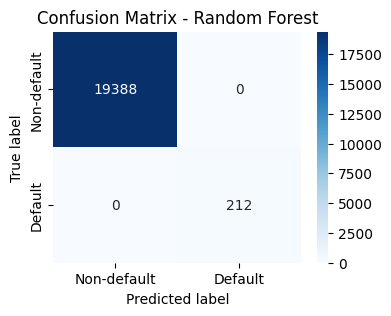

In [182]:

# attempted to filter out rows with more than half zero's. Discontinued due to data imbalance
# df['zero_count'] = df[billing_months].isin([0]).sum(axis=1)
# v = df[~((df.EV == 0) & (df.zero_count > 6))]
# visualizeFeatureCount(v)
# v[v.EV == 0][billing_months].isin([0]).sum()